In [1]:
%load_ext autoreload
%autoreload 2
import os
#change current working directory to the parent directory
import sys

# Change working directory to ../ only if not already there
if not hasattr(sys, "_parent_dir_set"):
    parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
    if os.getcwd() != parent_dir:
        os.chdir(parent_dir)
    sys._parent_dir_set = parent_dir
else:
    parent_dir = sys._parent_dir_set
# Add parent_dir to sys.path only if not already present
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

import numpy as np
from SRtools import sr_mcmc as srmc
import argparse
from SRtools import config_lib as cl
from SRtools import deathTimesDataSet as dtds
import ast
from SRtools import readResults as rr
import corner
import matplotlib.pyplot as plt
import matplotlib
from SRtools import SRmodellib as sr
from SRtools import SRmodellib_lifelines as srl
import emcee
from SRtools import samples_utils as su
from SRtools import joint_posterior as jp
from SRtools import SR_hetro as srh
from SRtools import life_table as lt

In [2]:
from numpy import True_


config_name = 'ecoli'

config_path = f"configurations_baysian.xlsx"
config = cl.read_excel_config(config_path, config_name)
cfg = cl.config_to_dict(config, mcmc_convert=True)
base_products_folder = os.path.join('analysis','products_baysian')
subfolder = None

test_mode = bool(int(cfg.get('test', 0)))
if test_mode:
    test_idx = 1  # Use test index 0
    post_path = os.path.join(base_products_folder,'posteriors', config_name+f'_{test_idx}_post.csv')
else:    
    post_path = os.path.join(base_products_folder,'posteriors', config_name+'_post.csv')
# Make sure the posterior directory exists before anything else
posterior_dir = os.path.join(base_products_folder, 'posteriors')
os.makedirs(posterior_dir, exist_ok=True)

summery_file_name = None
help_text ="Run for celegans"
apply_thresh = True
POST_CREATED =  bool(int(cfg.get('POST_CREATED',False)))

# POST_CREATED =False
SAVE_PRODUCTS =True
FAST = False
parallel = True
override = True
auto_thresh = True
thresh_max = 300



In [3]:
#get the name of current folder:
current_folder = os.path.basename(os.getcwd())

In [4]:
if POST_CREATED:
    post = su.Posterior.load_from_file(post_path)
    #########################################################
    config =post.config_params
    npeople = config['npeople']
    t_end = config['t_end']
    nwalkers = config['nwalkers']
    nsteps = config['nsteps']
    num_mcmc_steps = config['n_mcmc_steps']
    metric = config['metric']
    time_range = config.get('time_range',None)
    time_step_multiplier = config['time_step_multiplier']
    data_file = config.get('data_file',None)
    seed_file = config.get('seed_file',None)
    variations = config.get('variations')
    prior = config.get('prior')
    transform = config.get('transform',True)
    index = config.get('index',1)
    external_hazard = config.get('external_hazard',None)
    if isinstance(external_hazard, str):
        external_hazard = ast.literal_eval(external_hazard)
    hetro = config.get('hetro', False)
    submission_folder = config['submission_folder']
    test_mode = bool(int(config.get('test', 0)))
    n_tests = config.get('n_tests', 1)
    ndims = config.get('ndims', 4)
    dt = config.get('dt',1)
    nbins = int(config.get('nbins',100))
    TIME_UNIT = config.get('TIME_UNIT','days')


else:
    npeople = int(cfg.get('npeople'))
    t_end = int(cfg.get('t_end'))
    nwalkers = int(cfg.get('nwalkers'))
    nsteps = int(cfg.get('nsteps'))
    num_mcmc_steps = int(cfg.get('n_mcmc_steps'))
    metric = cfg.get('metric')
    time_range = cfg.get('time_range')
    if isinstance(time_range, str):
        time_range = ast.literal_eval(time_range)
    time_step_multiplier = int(cfg.get('time_step_multiplier'))
    data_file = cfg.get('data_file')
    seed_file = cfg.get('seed_file')
    variations = cfg.get('variations')
    prior = cfg.get('prior')
    transform = bool(cfg.get('transform'))
    index = int(cfg.get('index'))
    submission_folder = cfg.get(f'submission_folder')
    external_hazard =cfg.get('external_hazard')
    hetro = bool(cfg.get('hetro', False))
    test_mode = bool(int(cfg.get('test', 0)))
    n_tests = cfg.get('n_tests', 1)
    ndims = cfg.get('ndims', 4)
    dt = cfg.get('dt',1)
    nbins = int(cfg.get('nbins',100))
    TIME_UNIT = cfg.get('TIME_UNIT','days')
#all paths are in absolute paths (start with ~/). change all paths to be relative to the current folder 
# (remove everything before the current folder name)
submission_folder = submission_folder.split(current_folder)[-1]
#remove the first / from the paths

submission_folder = submission_folder[1:]

# In test mode, adjust paths to use test index subfolder
if test_mode:
    name = str(cfg.get('name'))
    # Store base submission folder for datasets path
    base_submission_folder = submission_folder
    # Modify submission_folder to point to test subfolder
    submission_folder = f"{submission_folder}/test_{test_idx}"
    # Modify data_file to point to dataset in test mode (datasets are at base submission level)
    datasets_folder = f"{base_submission_folder}/datasets"
    data_file = f"{datasets_folder}/{name}_dataset_{test_idx}.csv"
else:
    data_file = data_file.split(current_folder)[-1]
    data_file = data_file[1:]
    
h5_folder = f"{submission_folder}/h5_files"

In [5]:
if test_mode:
    test_str = f'_test_{test_idx}'
else:
    test_str = ''

if SAVE_PRODUCTS:
    Products_folder = base_products_folder

    if subfolder is not None:
        path = os.path.join(Products_folder,subfolder, config_name+test_str)
        results_path = os.path.join(Products_folder,'results_csvs',subfolder,config_name+test_str+'result_table.csv')
        path_days = os.path.join(Products_folder,'results_csvs_days',config_name+test_str+'result_table_days.csv')
    else:
        path = os.path.join(Products_folder, config_name)
        results_path = os.path.join(Products_folder,'results_csvs',config_name+test_str+'result_table.csv')
        path_days = os.path.join(Products_folder,'results_csvs_days',config_name+test_str+'result_table_days.csv')
    # Create all necessary directories if they don't exist
    os.makedirs(os.path.dirname(results_path), exist_ok=True)
    os.makedirs(os.path.dirname(path_days), exist_ok=True)
else:
    results_path=None
    path_days=None
    path=None

if TIME_UNIT == 'days':
    scale = None
elif TIME_UNIT == 'hours':
    scale = 1/24
elif TIME_UNIT == 'years':
    scale = 365
elif TIME_UNIT == 'weeks':
    scale = 7
elif TIME_UNIT == 'generations':
    scale = 1/8
else:
    raise ValueError(f"Invalid TIME_UNIT: {TIME_UNIT}")



# print(f"Loading file from: {path}")

In [6]:
ds = dtds.dsFromFile(data_file, properties=['death dt'])
ds.external_hazard = external_hazard
eta = float(cfg.get('eta'))
beta = float(cfg.get('beta'))
epsilon = float(cfg.get('epsilon'))
xc = float(cfg.get('xc'))
seed_ExtH = cfg.get('ExtH',None)
if seed_ExtH is not None and seed_ExtH != '':
    seed_ExtH = float(seed_ExtH)
else:
    seed_ExtH = None
seed = [eta,beta,epsilon,xc,seed_ExtH]
seed = seed[0:ndims]
if transform:
    seed_trans = srmc.transform(seed)

In [7]:
if POST_CREATED:
    pass
else:
    samples_trans0, lnprobs0 = srmc.loadSamplesFromDir(h5_folder, best=False, thin =5, discard=200, debug=True)


In [8]:
if not POST_CREATED:
    print('len(samples_trans0)',len(samples_trans0))
    print('len(lnprobs0)',len(lnprobs0))
    print('np.max(lnprobs0)',np.max(lnprobs0))

In [9]:
if not POST_CREATED:
    #plot a histogram of lnprobs2
    #thresh is the threshold for lnprobs. lnprobs below thresh are not plotted
    #thresh is the 95th percentile of lnprobs
    if auto_thresh:
        # Remove lnprobs that are -inf
        valid_mask = ~np.isneginf(lnprobs0)
        lnprobs0_valid = lnprobs0[valid_mask]
        # Optionally, also mask samples_trans0 etc. if needed elsewhere

        # Calculate two thresholds:
        thresh_maxm350 = np.max(lnprobs0_valid) - thresh_max
        thresh_60perc = np.percentile(lnprobs0_valid, 60)

        # Pick the one that includes more samples (is lower)
        if np.sum(lnprobs0_valid > thresh_maxm350) > np.sum(lnprobs0_valid > thresh_60perc):
            thresh = thresh_maxm350
            print(f"thresh (max-{thresh_max}): {thresh}")
        else:
            thresh = thresh_60perc
            print(f"thresh (60th percentile): {thresh}")
    else:
        thresh = np.percentile(lnprobs0, 60)
        print(f"thresh: {thresh}")
    # thresh =-np.inf

    plt.hist(lnprobs0[lnprobs0>thresh], bins=100, alpha=0.75)
    plt.xlabel('lnprobs')
    plt.ylabel('Frequency')
    plt.title('Histogram of lnprobs')
    plt.grid(True)
    plt.show()

In [10]:
if POST_CREATED:
    if not isinstance(post, jp.JointPosterior):
        samples_trans =post.samples
        lnprobs = post.lnprobs
        best_theta_trans = post.best_raw_sample()
    else:
        best_theta_trans = post.get_mode()
else:
    if apply_thresh:
        samples_trans = samples_trans0[lnprobs0>thresh]
        lnprobs = lnprobs0[lnprobs0>thresh]

In [11]:
if POST_CREATED:
    pass
else:
    print(len(lnprobs0))

In [12]:
if not POST_CREATED:
    config_dict = cl.config_to_dict(config)
    post = su.Posterior(samples_trans, lnprobs, nbins, log=True,config_params=config_dict,help_text=help_text)
    if post_path is not None:
        post.save_to_file(post_path)
        config['DEFAULT']['POST_CREATED'] = 1
    config.write()
    best_theta_trans = post.best_raw_sample()


In [13]:
if not isinstance(post, jp.JointPosterior):
    samples =np.array([srmc.inv_transform(sample) for sample in samples_trans])
best_theta = srmc.inv_transform(best_theta_trans)


# # 1. Density coner plot
A sample is 1 parameter set scanned.
For the corner plot below, the quantiles (represented by the solid lines) are 0.16,0.5,0.84 of the samples. Dots represent individual samples (outside the line surrounding 0.84 of the samples)
The parameter search is performed in the transformed space of $x_c/\eta$, $\beta/\eta$, $x_c^2/\epsilon$, $x_c$ but we also show the regular parameters


In [14]:
if test_mode:
    truths_trans =seed_trans
    truths = seed
else:
    truths_trans = best_theta_trans
    truths = best_theta

In [15]:
labels_trans = ["$x_c/\\eta$","$\\beta/\\eta$","$x_c^2/\\epsilon$","$x_c$","EextH"]
labels_trans = labels_trans[0:ndims]

(16,)


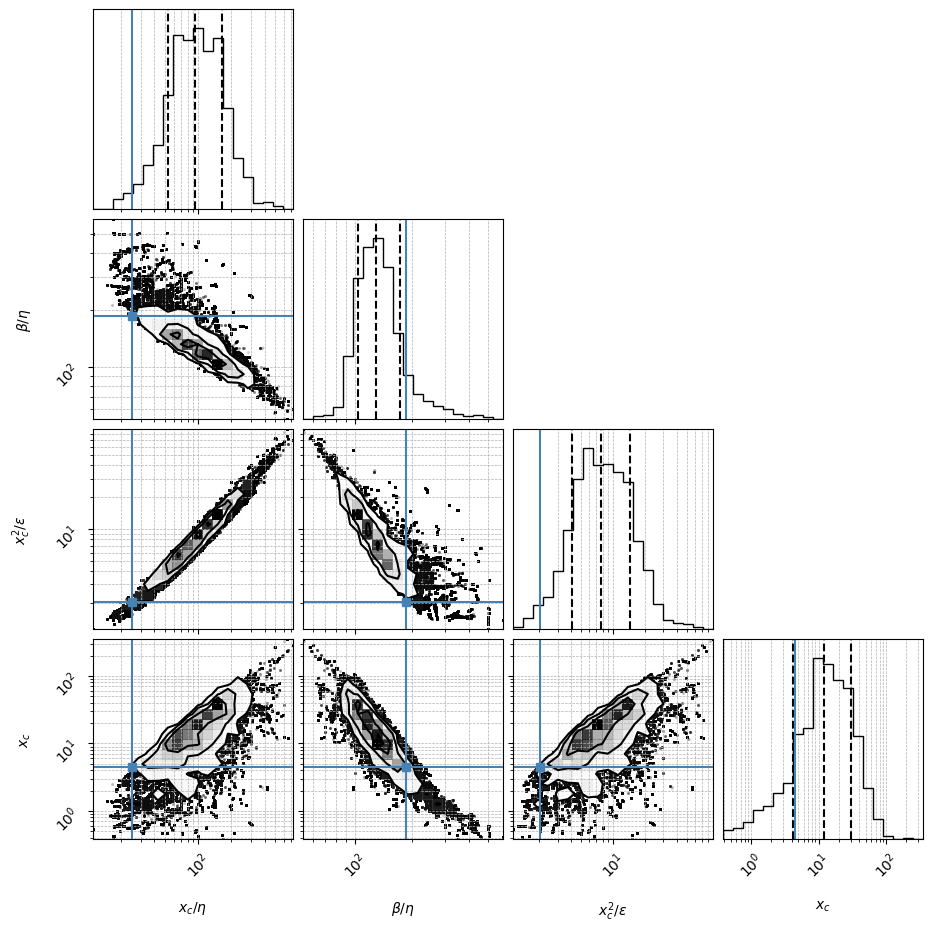

In [16]:
if not FAST:
    if not isinstance(post, jp.JointPosterior):
        fig = corner.corner(samples_trans, labels=labels_trans, axes_scale='log',quantiles=[0.16, 0.5, 0.84], truths=truths_trans)
        axes=fig.get_axes()
        print(np.shape(axes))
        for ax in axes:
            ax.grid(True, which='both', linestyle='--', linewidth=0.5)

In [17]:
labels = ['eta','beta','epsilon','xc','Hext']
labels = labels[0:ndims]

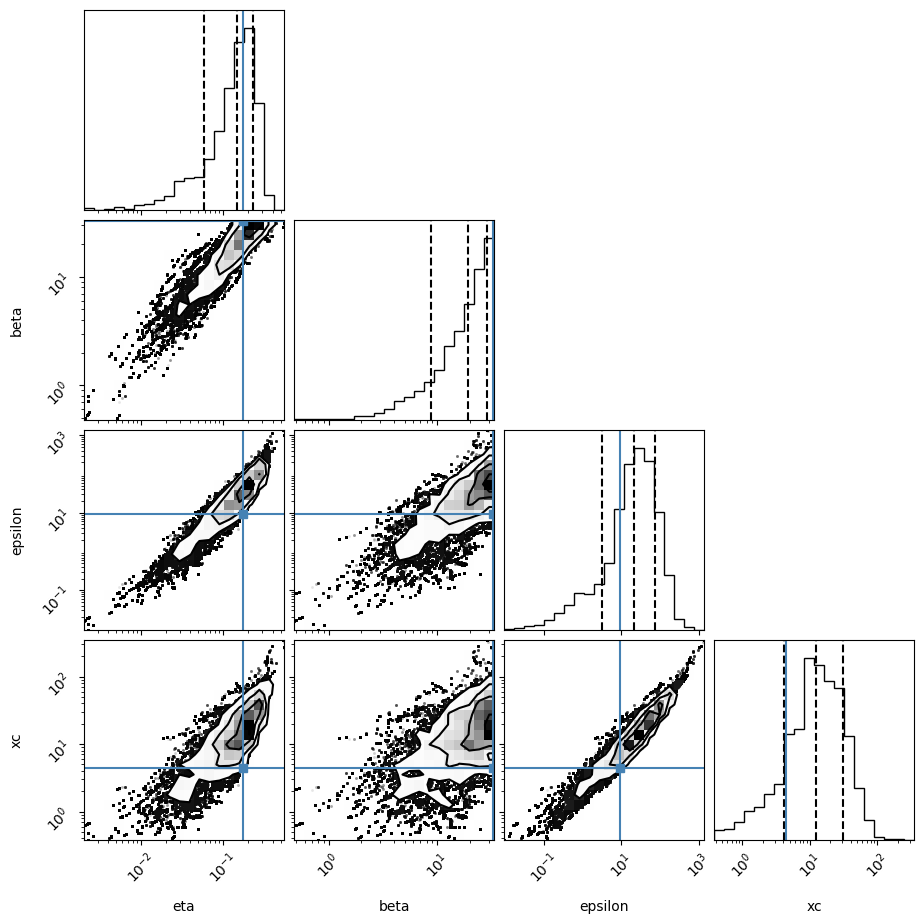

In [18]:
if not FAST:
    if not isinstance(post, jp.JointPosterior):
        fig = corner.corner(samples, labels=labels,axes_scale='log',quantiles=[0.16, 0.5, 0.84], truths=truths)

# 2. Heat map corner plot of raw  samples
This plot shows all the raw sample points and their lnprobability

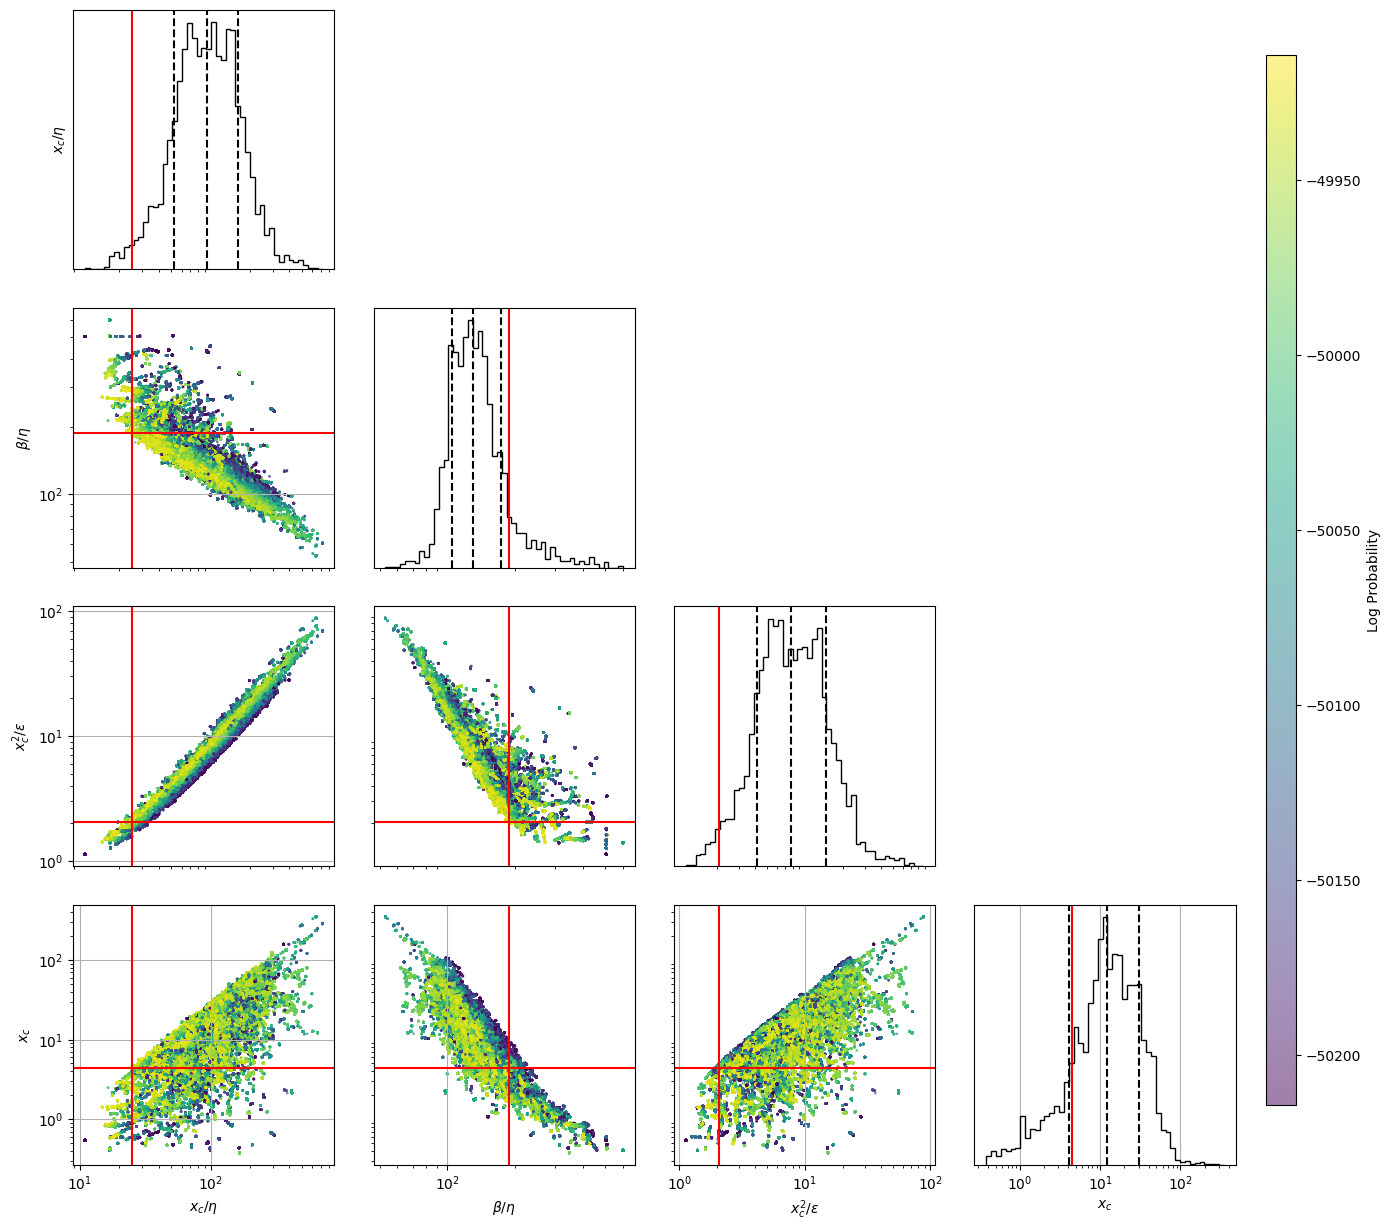

In [19]:
if not FAST:
    if not isinstance(post, jp.JointPosterior):
        fig,ax=srmc.custom_corner(samples_trans,lnprobs, truths= truths_trans, labels=labels_trans, show_color_bar=True)

# 3. Posterior distributions of parameters

1d marginalizations of posterior distributions. we use a grid of size nbins=100-150

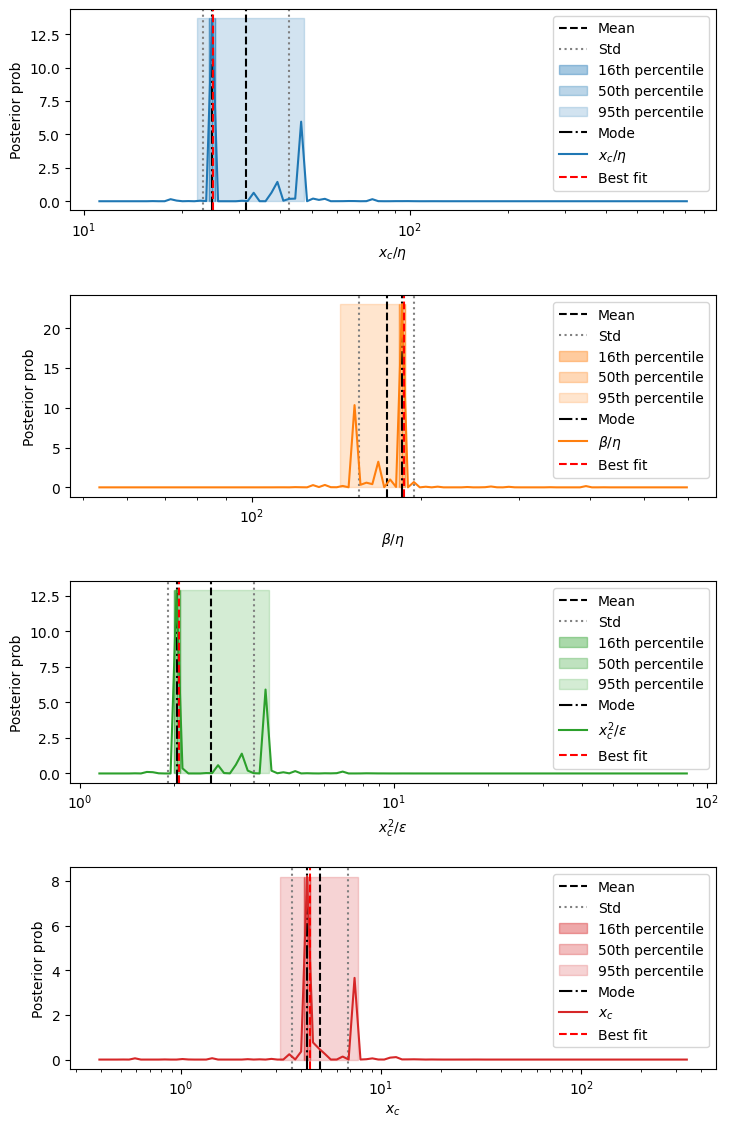

In [20]:
post.plot_1d_posteriors(labels=labels_trans, truths=truths_trans,scale='log',show_ln_prob=False,smooth_mode=False)

2D marginalizations of posterior distributions 

/Volumes/alon/navehr/SRtools/SRtools/samples_utils.py:474: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax.pcolormesh(X, Y, Z, **kwargs)


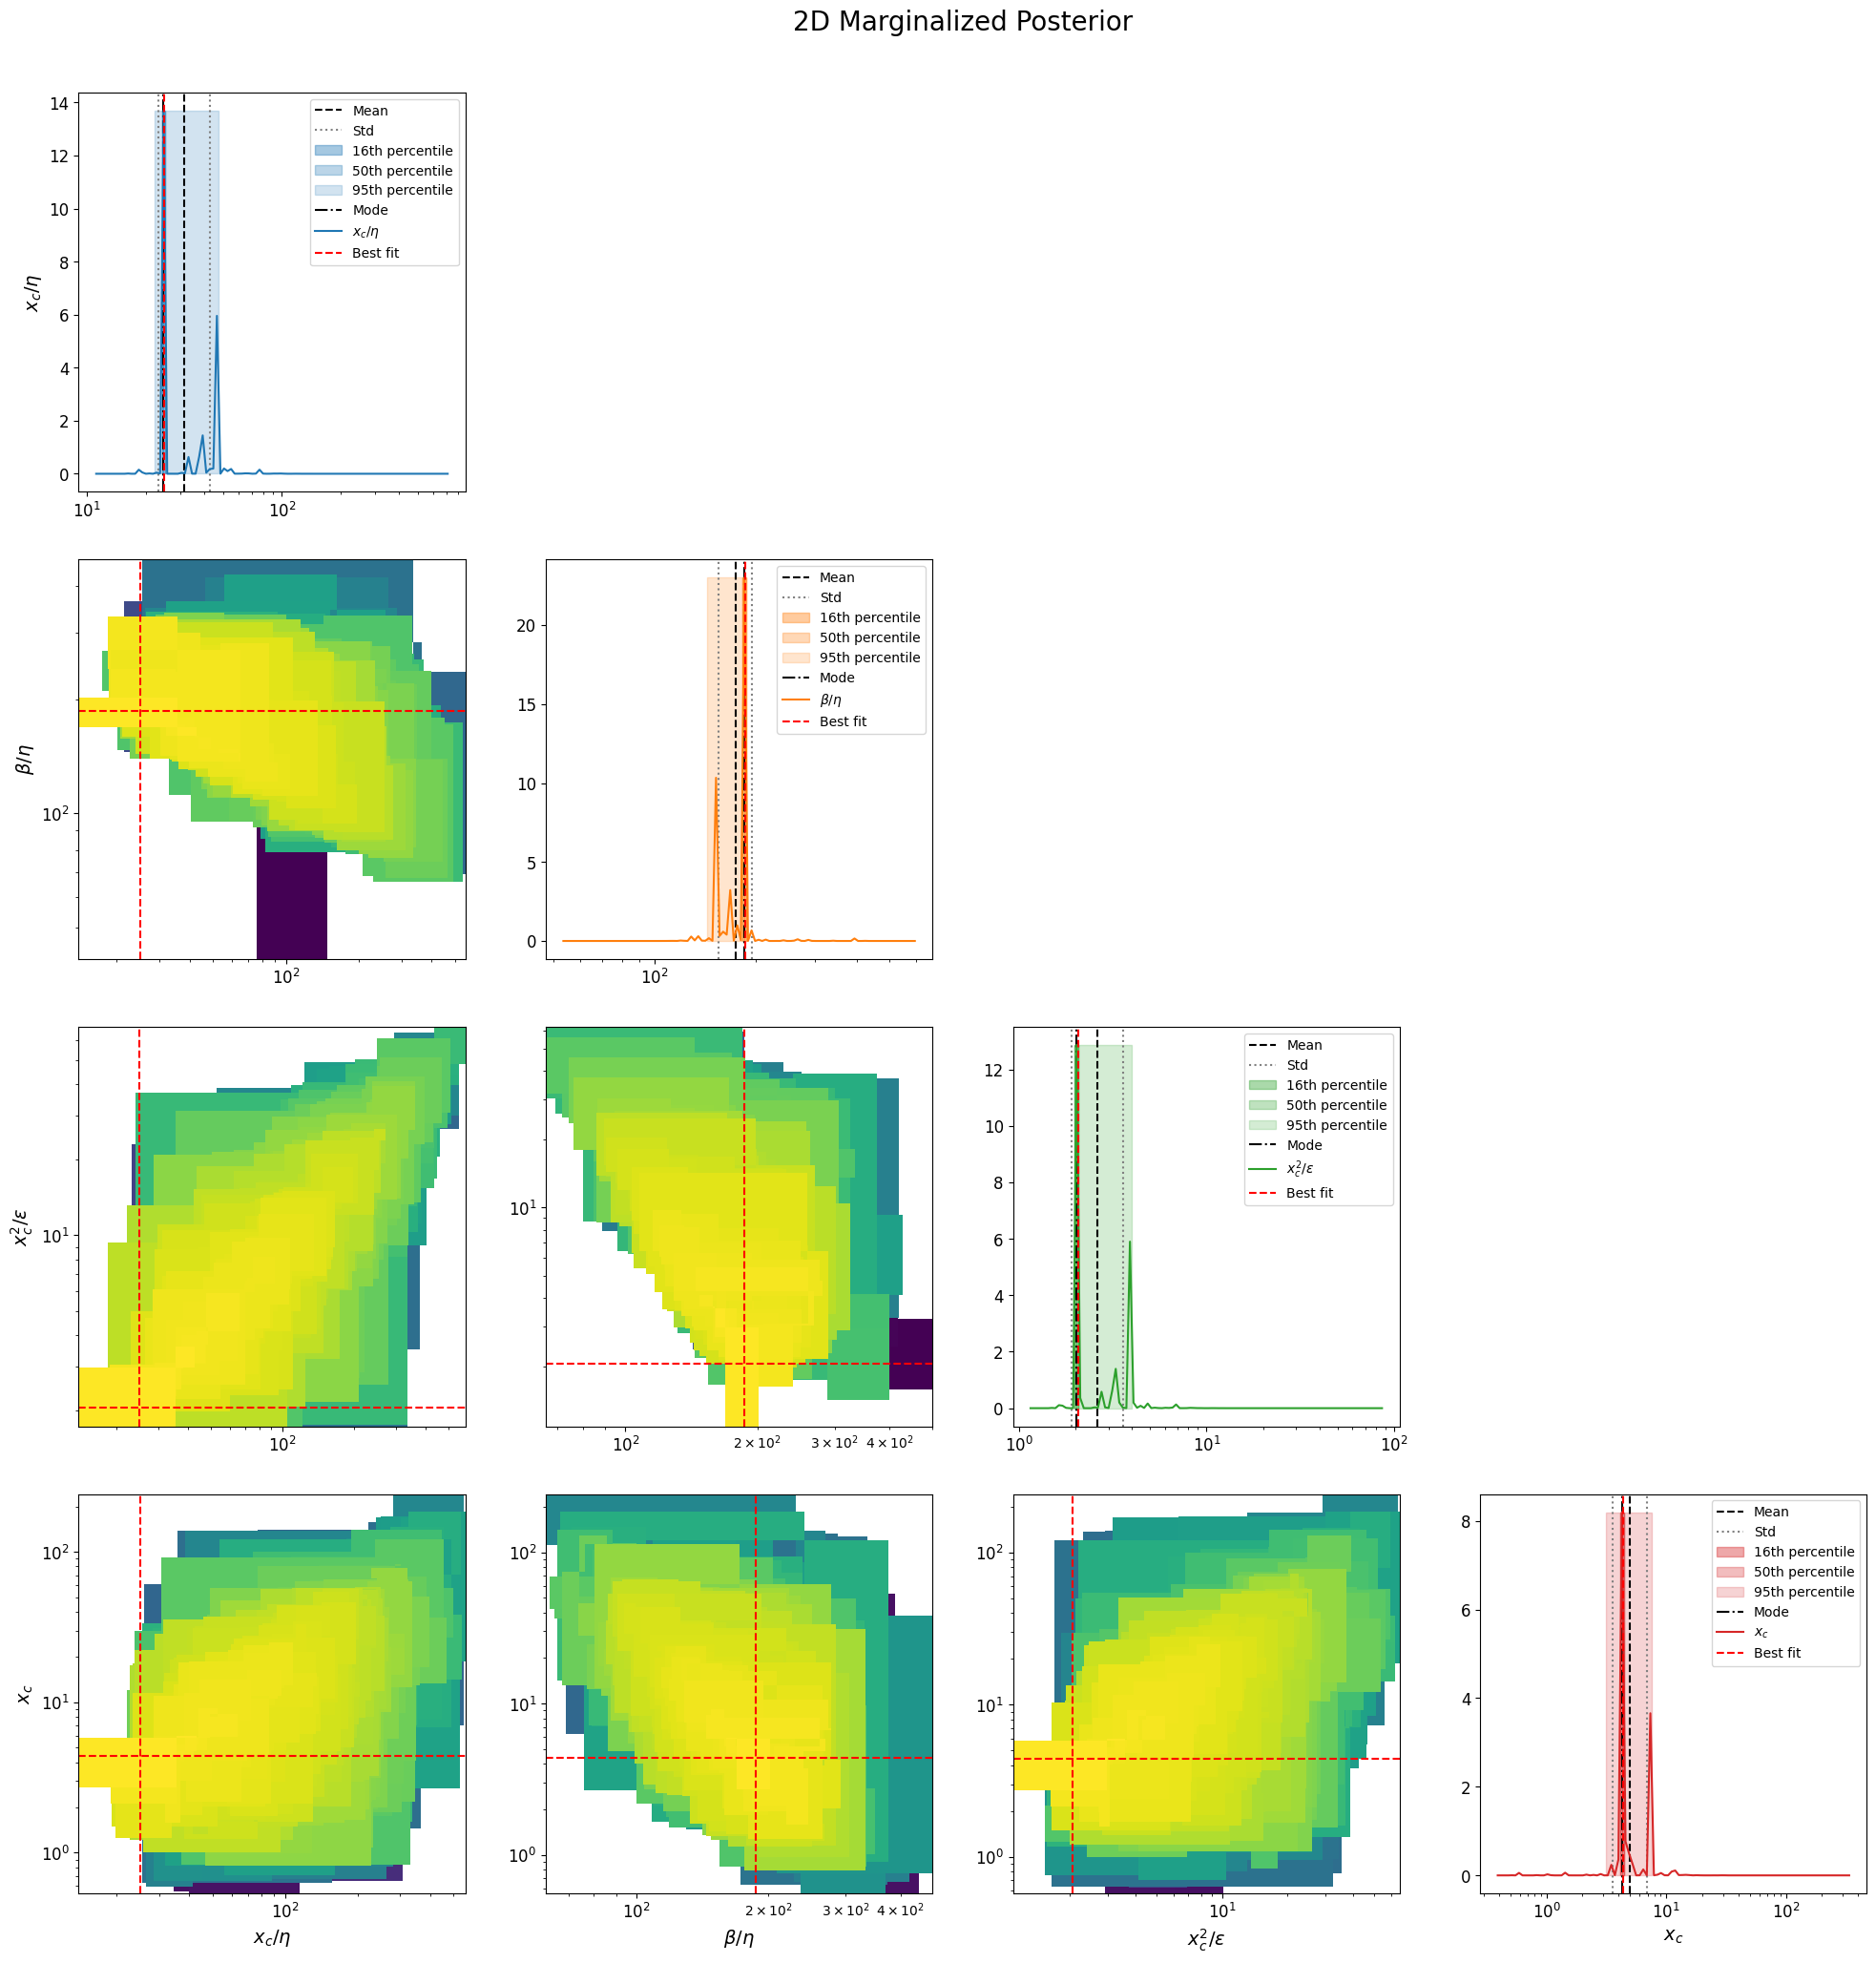

In [21]:
if not FAST:
    _=post.corner_plot(labels=labels_trans, truths=truths_trans,scale='log',show_ln_prob=False,norm='log',plot_type="pcolormesh")

In [22]:
fig =post.plot_posterior3D_interactive([0,1,2],labels=labels_trans, truths=np.log(truths_trans),truth_label="Best fit" )
# Save the figure using matplotlib's savefig instead of plotly's write_image
fig.show()
if SAVE_PRODUCTS:
    # Save the figure as HTML
    html_file_name = config_name+test_str+'_3D_plot'
    if subfolder is not None:
        html_file_name = os.path.join(subfolder, html_file_name)
    html_path = os.path.join(Products_folder, 'html_3d_plots', f'{html_file_name}.html')
    # Create directory if it doesn't exist
    os.makedirs(os.path.dirname(html_path), exist_ok=True)
    fig.write_html(html_path)

In [23]:
if ndims == 5:
    external_hazard_estimate = best_theta[-1]
else:
    external_hazard_estimate = None
best_sim = srh.getSrHetro(best_theta, nsteps=nsteps, npeople=npeople, time_step_multiplier=time_step_multiplier, t_end=t_end, external_hazard=external_hazard_estimate,hetro =hetro,parallel=parallel)
best_sim_no_ext_hazard = srh.getSrHetro(best_theta, nsteps=nsteps, npeople=npeople, time_step_multiplier=time_step_multiplier, t_end=t_end, external_hazard=None,hetro =hetro,parallel=parallel)

In [24]:
if SAVE_PRODUCTS:
    save_path = results_path
else:
    save_path = None
if test_mode:
    truth_df = seed_trans
else:
    truth_df =None
df=post.create_posterior_df(filepath=save_path, ds = [best_sim_no_ext_hazard,best_sim,ds], ds_labels=['best fit no ext hazard','best fit','data'],truth=truth_df)


In [25]:
#creating a new df with the results in days
if TIME_UNIT != 'days':
    df_days=post.create_posterior_df(filepath=path_days, ds = [best_sim_no_ext_hazard,best_sim,ds], ds_labels=['best fit no ext hazard','best fit','data'],rescale=scale,truth=truth_df)
else:
    df_days=df
    if path_days is not None:
        df_days.to_csv(path_days)


Rescaling the samples TIME by 0.041666666666666664


# 4. Table of results

mode is the marginalized mode,
max_likwlihood is the sample with highest likelihood
mode_overall is the 4D posterior mode


In [26]:
df

,mean,std,mode,percentile_16,percentile_50,percentile_95,max_likelihood,mode_overall
xc/eta,31.424,"[8.262, 11.209]",24.762,"[24.248, 25.287]","[24.248, 25.287]","[22.298, 47.431]",24.982,24.982
beta/eta,174.055,"[18.672, 20.916]",185.312,"[183.07, 187.581]","[183.07, 187.581]","[143.511, 187.581]",186.673,186.673
xc^2/epsilon,2.607,"[0.706, 0.969]",2.031,"[1.987, 2.075]","[1.987, 2.075]","[1.987, 3.991]",2.061,2.061
xc,4.967,"[1.373, 1.898]",4.275,"[4.132, 4.424]","[4.132, 4.424]","[3.144, 7.638]",4.408,4.408
eta,0.163,"[0.0249, 0.0294]",0.174,"[0.17, 0.179]","[0.17, 0.179]","[0.121, 0.201]",0.176,0.176
beta,28.891,"[4.733, 5.66]",32.747,"[32.06, 33.45]","[32.06, 33.45]","[20.969, 33.45]",32.936,32.936
epsilon,10.036,"[3.141, 4.573]",9.902,"[9.329, 10.509]","[9.329, 10.509]","[5.794, 24.187]",9.426,9.426
sqrt(xc/eta),5.609,"[0.841, 0.989]",4.976,"[4.924, 5.029]","[4.924, 5.029]","[4.722, 7.182]",4.998,4.998
s= eta^0.5*xc^1.5/epsilon,0.469,"[0.0751, 0.0893]",0.412,"[0.407, 0.417]","[0.407, 0.417]","[0.37, 0.587]",0.412,0.412
beta*xc/epsilon,14.614,"[1.629, 1.834]",15.454,"[15.285, 15.624]","[15.285, 15.624]","[11.0, 15.624]",15.401,15.401


In [27]:
if SAVE_PRODUCTS:
    ####GO OVER THIS BEFORE SAVING!!!!!!!!!!!!###################################################
    import pandas as pd
    import SRtools.utils as ut
    summery_csv_base_name='summery'
    # Create paths for the three summary CSV files
    mode_summary_path = os.path.join(base_products_folder, f'{summery_csv_base_name}_mode.csv')
    max_likelihood_summary_path = os.path.join(base_products_folder, f'{summery_csv_base_name}_max_likelihood.csv')
    mode_overall_summary_path = os.path.join(base_products_folder, f'{summery_csv_base_name}_mode_overall.csv')

    # Get the relevant values from df_days
    file_name = config_name+test_str
    mode_values = df_days['mode'].copy()
    max_likelihood_values = df_days['max_likelihood'].copy()
    mode_overall_values = df_days['mode_overall'].copy()
    # Get the 95% confidence intervals from df_days
    ci_values = df_days['percentile_95'].copy()
    # Convert CI values to string representation
    ci_values = ci_values.apply(lambda x: f"[{x[0]}, {x[1]}]" if isinstance(x, (list, tuple, np.ndarray)) else x)



    # Add file name as column name
    mode_values = pd.DataFrame(mode_values.values, columns=[file_name], index=mode_values.index)
    mode_values[f'{file_name} 95% CI'] = ci_values
    max_likelihood_values = pd.DataFrame(max_likelihood_values.values, columns=[file_name], index=max_likelihood_values.index)
    mode_overall_values = pd.DataFrame(mode_overall_values.values, columns=[file_name], index=mode_overall_values.index)



    # Save the data
    ut.append_or_create_csv(mode_values, mode_summary_path,override=override)
    ut.append_or_create_csv(max_likelihood_values, max_likelihood_summary_path,override=override)
    ut.append_or_create_csv(mode_overall_values, mode_overall_summary_path,override=override)

    # If in test mode, also create an error CSV with specified columns, adding file_name to column headers
    if test_mode:
        error_columns = [
            'error_mode',
            'error_max_likelihood',
            'error_mean',
            'error_mode_overall',
            'ci95_size_pct',
            'in_percentile_16_CI',
            'in_percentile_50_CI',
            'in_percentile_95_CI',
            'in_std_CI',
        ]
        # Only select error columns that exist in df_days
        columns_present = [col for col in error_columns if col in df_days.columns]
        error_df_raw = df_days[columns_present].copy()
        # Create a MultiIndex column if more than one experiment, otherwise just use file_name as suffix
        error_df = error_df_raw.rename(columns={col: f"{file_name} {col}" for col in columns_present})
        error_csv_path = os.path.join(base_products_folder, f'{summery_csv_base_name}_error.csv')
        ut.append_or_create_csv(error_df, error_csv_path, override=True)


In [28]:
# if SAVE_PRODUCTS:
#     ####GO OVER THIS BEFORE SAVING!!!!!!!!!!!!###################################################
#     import pandas as pd
#     import SRtools.utils as ut

#     # Create configuration parameters DataFrame
#     config_params = pd.DataFrame.from_dict(config, orient='index', columns=[file_name])

#     # Create a new DataFrame with the additional parameters
#     additional_params = pd.DataFrame({
#         file_name: [nbins, seed, seed_trans]
#     }, index=['nbins', 'seed', 'seed_trans'])

#     # Concatenate the DataFrames
#     config_params = pd.concat([config_params, additional_params])

#     # Save configuration parameters
#     config_summary_path = os.path.join(Products_folder, f'All_config.csv')
#     ut.append_or_create_csv(config_params, config_summary_path, override=True)

In [29]:
#get the theta of the modes of the posterior (from the df) location of indexes eta, beta, epsilon, xc and columen 'mode'

theta_mode_trans = post.get_best_sample_in_mode()
external_hazard = best_theta[-1] if ndims == 5 else None
sim_mode_trans = srh.getSrHetro(srmc.inv_transform(theta_mode_trans), nsteps=nsteps, npeople=npeople, time_step_multiplier=time_step_multiplier, t_end=t_end, external_hazard=external_hazard,parallel=True,hetro=hetro)


# 5. Fits of simulations to data
best params is the sample with highest likelihood. 
mode trans is the 4D posterior mode in the transformed space of $x_c/\eta$, $\beta/\eta$, $x_c^2/\epsilon$, $x_c$

Text(0, 0.5, 'Hazard')

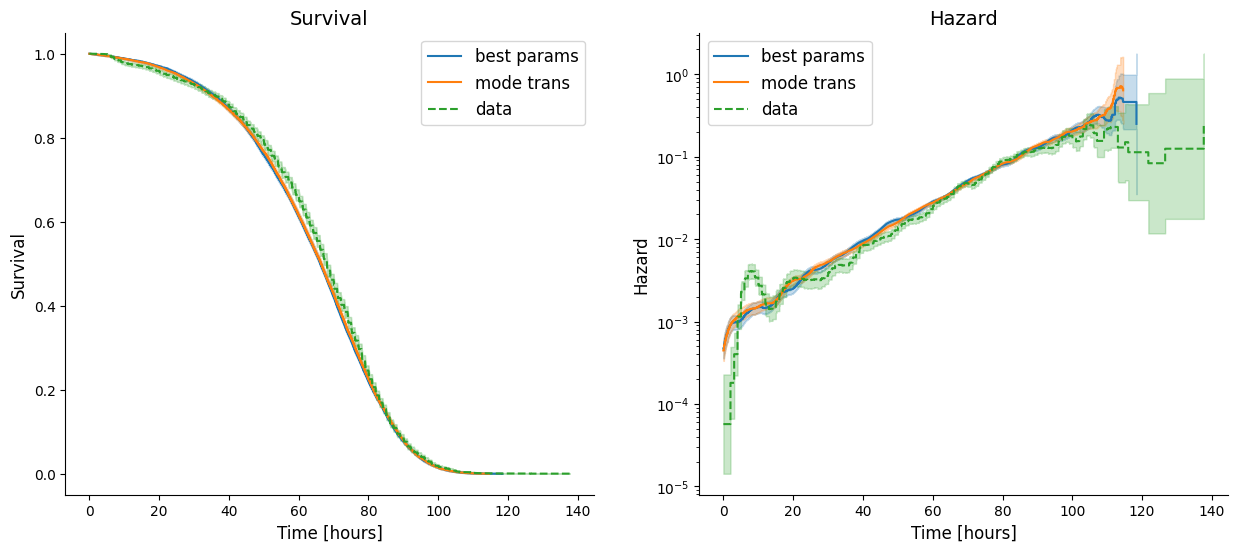

In [30]:
# Define parameters for consistent styling
TITLE_FONTSIZE = 14
AXIS_FONTSIZE = 12
LEGEND_FONTSIZE = 12


fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot survival on ax[0]
ax0 = best_sim.plotSurvival(ax=axs[0],time_range=time_range, label='best params', 
                           title='Survival', xlabel=f'time [{TIME_UNIT}]', ylabel='survival')
sim_mode_trans.plotSurvival(ax=ax0,time_range=time_range, label='mode trans')
ds.plotSurvival(ax=ax0,time_range=time_range, label='data', linestyle='--')  # Made data dashed
ax0.legend(fontsize=LEGEND_FONTSIZE)
ax0.set_title('Survival', fontsize=TITLE_FONTSIZE)
ax0.set_xlabel(f'Time [{TIME_UNIT}]', fontsize=AXIS_FONTSIZE)
ax0.set_ylabel('Survival', fontsize=AXIS_FONTSIZE)


# Plot hazard on ax[1]
ax1 = best_sim.plotHazard(ax=axs[1], title='Hazard', xlabel=f'time [{TIME_UNIT}]', 
                         ylabel='hazard', label='best params')
sim_mode_trans.plotHazard(ax=ax1, label='mode trans')
ds.plotHazard(ax=ax1, label='data', linestyle='--')  # Made data dashed
ax1.set_yscale('log')
ax1.legend(fontsize=LEGEND_FONTSIZE)
ax1.set_title('Hazard', fontsize=TITLE_FONTSIZE)
ax1.set_xlabel(f'Time [{TIME_UNIT}]', fontsize=AXIS_FONTSIZE)
ax1.set_ylabel('Hazard', fontsize=AXIS_FONTSIZE)

Text(0, 0.5, 'Prob density')

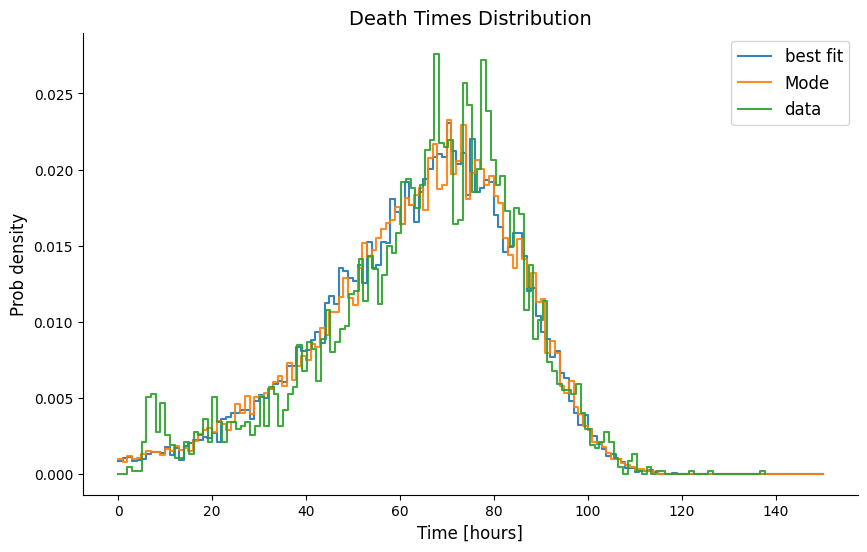

In [31]:
#add plots of the death time distributions of the best fit and data:
fig,ax = plt.subplots(1,1, figsize=(10,6))

best_sim.plotDeathTimesDistribution(ax=ax,use_kde=False,dt=dt , label='best fit',alpha=0.9)
sim_mode_trans.plotDeathTimesDistribution(ax=ax,use_kde=False,dt=dt, label='Mode',alpha=0.9)
ds.plotDeathTimesDistribution(ax=ax,use_kde=False ,dt=dt,label='data',alpha=0.9)
ax.legend(fontsize=LEGEND_FONTSIZE)
ax.set_title('Death Times Distribution', fontsize=TITLE_FONTSIZE)
ax.set_xlabel(f'Time [{TIME_UNIT}]', fontsize=AXIS_FONTSIZE)
ax.set_ylabel('Prob density', fontsize=AXIS_FONTSIZE)
